In [9]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm


# Assuming the uploaded file is named 'option_GS_df.csv'
df = pd.read_csv('option_GS_df.csv')

# Filter out rows where 'Bid' is 0.00
df = df[df['Bid'] > 0].reset_index(drop=True)

# Calculate m_price by rounding up the Bid values
df['m_price'] = np.ceil(df['Bid']).astype(int)

# Select the first 5 rows
df_first_5 = df.head().copy()

# Black-Scholes formula for European Call and Put options
def black_scholes(S, K, T, r, sigma, option_type="call"):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == "call":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Binomial Options Pricing Model
def binomial_model(S, K, T, r, sigma, N, option_type="call", american=False):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    
    # Initialize asset prices at maturity
    ST = np.zeros(N + 1)
    for i in range(N + 1):
        ST[i] = S * (u ** (N - i)) * (d ** i)
    
    # Initialize option values at maturity
    option_values = np.maximum(0, (ST - K) if option_type == "call" else (K - ST))
    
    # Backward induction
    for t in range(N - 1, -1, -1):
        for i in range(t + 1):
            option_values[i] = np.exp(-r * dt) * (p * option_values[i] + (1 - p) * option_values[i + 1])
            if american:
                option_values[i] = max(option_values[i], (S * (u ** (t - i)) * (d ** i) - K) if option_type == "call" else (K - S * (u ** (t - i)) * (d ** i)))
    
    return option_values[0]

# Initialize parameters
r = 0.01  # Risk-free rate
sigma = 0.2  # Volatility
T = 1 / 365  # Time to maturity (1 day for simplicity)
N = 100  # Number of time steps in binomial model

# Lists to store calculated prices
bs_call_prices = []
bs_put_prices = []
binomial_call_prices = []
binomial_put_prices = []

# Calculate prices for the first 5 rows
for i in range(5):
    S = df_first_5['UnderlyingPrice'][i]
    K = df_first_5['Strike'][i]
    
    bs_call = black_scholes(S, K, T, r, sigma, "call")
    bs_put = black_scholes(S, K, T, r, sigma, "put")
    
    binomial_call = binomial_model(S, K, T, r, sigma, N, "call", american=False)
    binomial_put = binomial_model(S, K, T, r, sigma, N, "put", american=False)
    
    bs_call_prices.append(bs_call)
    bs_put_prices.append(bs_put)
    binomial_call_prices.append(binomial_call)
    binomial_put_prices.append(binomial_put)

# Add calculated prices to the DataFrame
df_first_5.loc[:, 'BS_Call_Price'] = bs_call_prices
df_first_5.loc[:, 'BS_Put_Price'] = bs_put_prices
df_first_5.loc[:, 'Binomial_Call_Price'] = binomial_call_prices
df_first_5.loc[:, 'Binomial_Put_Price'] = binomial_put_prices

# Display the DataFrame with the first 5 rows
df_first_5[['UnderlyingPrice', 'Strike', 'Bid', 'm_price', 'BS_Call_Price', 'BS_Put_Price', 'Binomial_Call_Price', 'Binomial_Put_Price']]


,UnderlyingPrice,Strike,Bid,m_price,BS_Call_Price,BS_Put_Price,Binomial_Call_Price,Binomial_Put_Price
0,174.09,125.0,46.95,47,49.093425,2.092206e-221,49.093425,0.0
1,174.09,130.0,41.80,42,44.093562,7.615708e-173,44.093562,0.0
2,174.09,135.0,36.95,37,39.093699,7.401637e-132,39.093699,0.0
3,174.09,140.0,31.75,32,34.093836,1.106058e-97,34.093836,0.0
4,174.09,145.0,26.75,27,29.093973,1.182577e-69,29.093973,0.0


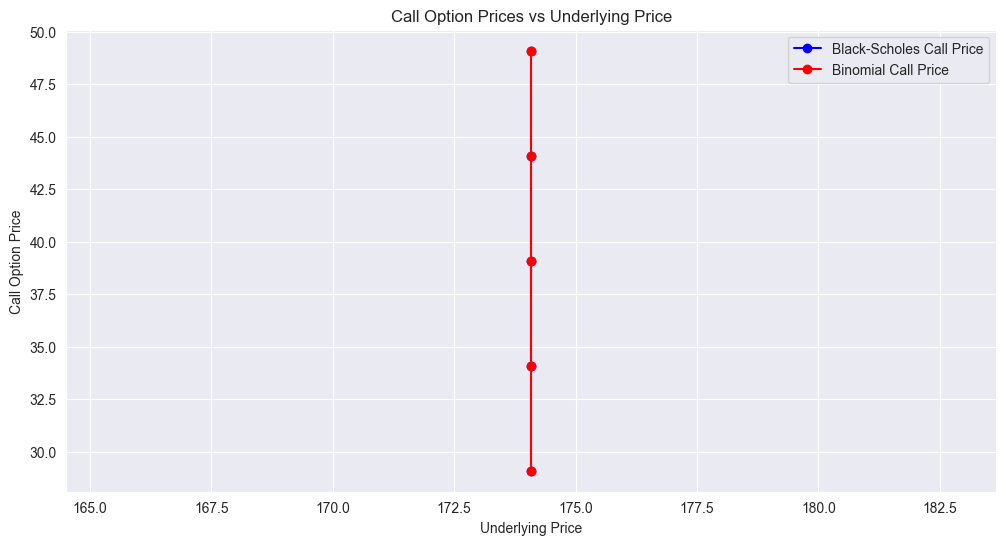

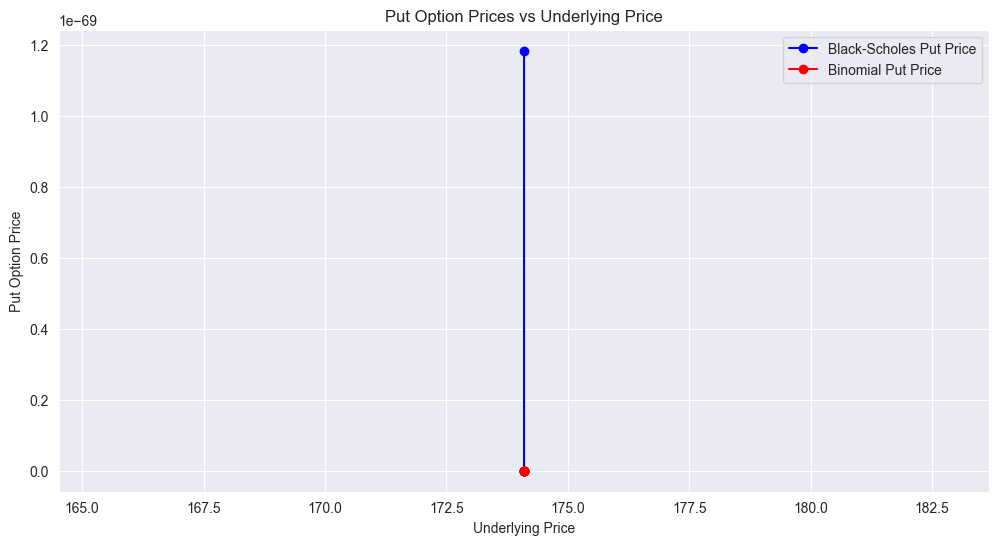

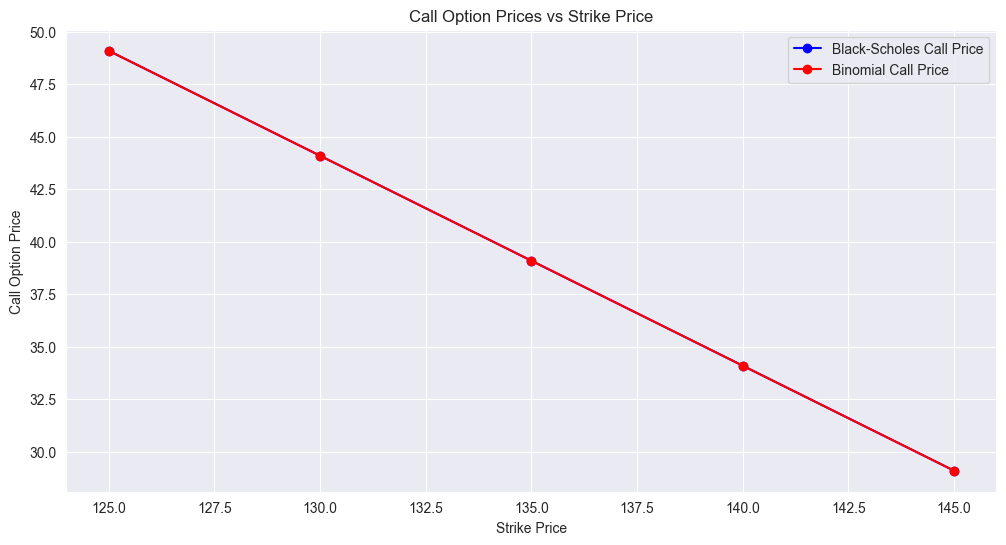

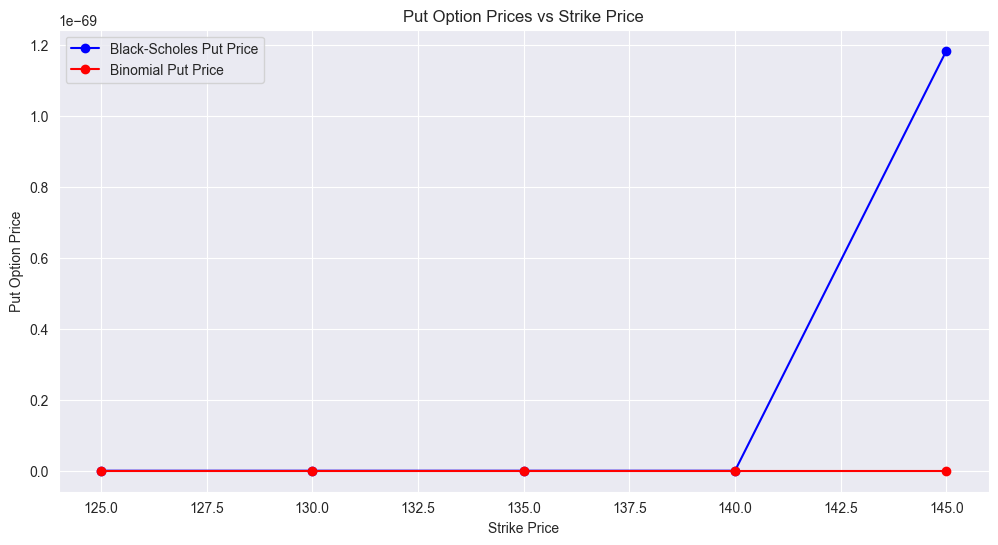

In [10]:
import matplotlib.pyplot as plt

# Plot UnderlyingPrice vs BS_Call_Price and Binomial_Call_Price
plt.figure(figsize=(12, 6))

plt.plot(df_first_5['UnderlyingPrice'], df_first_5['BS_Call_Price'], marker='o', linestyle='-', color='b', label='Black-Scholes Call Price')
plt.plot(df_first_5['UnderlyingPrice'], df_first_5['Binomial_Call_Price'], marker='o', linestyle='-', color='r', label='Binomial Call Price')

plt.title('Call Option Prices vs Underlying Price')
plt.xlabel('Underlying Price')
plt.ylabel('Call Option Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot UnderlyingPrice vs BS_Put_Price and Binomial_Put_Price
plt.figure(figsize=(12, 6))

plt.plot(df_first_5['UnderlyingPrice'], df_first_5['BS_Put_Price'], marker='o', linestyle='-', color='b', label='Black-Scholes Put Price')
plt.plot(df_first_5['UnderlyingPrice'], df_first_5['Binomial_Put_Price'], marker='o', linestyle='-', color='r', label='Binomial Put Price')

plt.title('Put Option Prices vs Underlying Price')
plt.xlabel('Underlying Price')
plt.ylabel('Put Option Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot Strike vs BS_Call_Price and Binomial_Call_Price
plt.figure(figsize=(12, 6))

plt.plot(df_first_5['Strike'], df_first_5['BS_Call_Price'], marker='o', linestyle='-', color='b', label='Black-Scholes Call Price')
plt.plot(df_first_5['Strike'], df_first_5['Binomial_Call_Price'], marker='o', linestyle='-', color='r', label='Binomial Call Price')

plt.title('Call Option Prices vs Strike Price')
plt.xlabel('Strike Price')
plt.ylabel('Call Option Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot Strike vs BS_Put_Price and Binomial_Put_Price
plt.figure(figsize=(12, 6))

plt.plot(df_first_5['Strike'], df_first_5['BS_Put_Price'], marker='o', linestyle='-', color='b', label='Black-Scholes Put Price')
plt.plot(df_first_5['Strike'], df_first_5['Binomial_Put_Price'], marker='o', linestyle='-', color='r', label='Binomial Put Price')

plt.title('Put Option Prices vs Strike Price')
plt.xlabel('Strike Price')
plt.ylabel('Put Option Price')
plt.legend()
plt.grid(True)
plt.show()
